# _My Own Gensim Walkthrough_

This walkthrough takes components from the following articles:

- [Traditional Methods for Text Data](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41)
- [A hands-on intuitive approach to Deep Learning Methods for Text Data — Word2Vec, GloVe and FastText](https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa)
- [gensim's Word2Vec Model tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)

In [25]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import gutenberg as gt
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
pd.options.display.max_colwidth = 200
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


## _Text pre-processing_

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

In [5]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


In [6]:
for i, word in enumerate(norm_bible):
    if i == 10:
        break
    print(word)

king james bible
old testament king james bible
first book moses called genesis
beginning god created heaven earth
earth without form void darkness upon face deep
spirit god moved upon face waters
god said let light light
god saw light good god divided light darkness
god called light day darkness called night
evening morning first day


In [15]:
from gensim import utils
class BibleCorpus(object):
    '''An iterator that yields sentences (lists of str)'''
    def __iter__(self):
        for line in norm_bible:
            yield utils.simple_preprocess(line)

In [16]:
sentences = BibleCorpus()

In [17]:
model = Word2Vec(sentences=sentences)

In [18]:
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

king
james
old
testament
first
book
moses
called
beginning
god


In [28]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def reduce_dimensions(model):
    num_dimensions = 2
    vectors = [] # positions in vector space
    labels = [] # keeps track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)
    # convert both list into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)
    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, early_exaggeration=6.0, random_state=0)
    vectors = tsne.fit_transform(vectors)
    
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [29]:
x_vals, y_vals, labels = reduce_dimensions(model)

In [30]:
import matplotlib.pyplot as plt
import random

def plot_with_matplotlib(x_vals, y_vals, labels, seed):
    random.seed(seed)
    plt.figure(figsize=(12,12))
    plt.scatter(x_vals, y_vals)
    # label randomly subsampled 25 data points
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]), fontweight='bold')

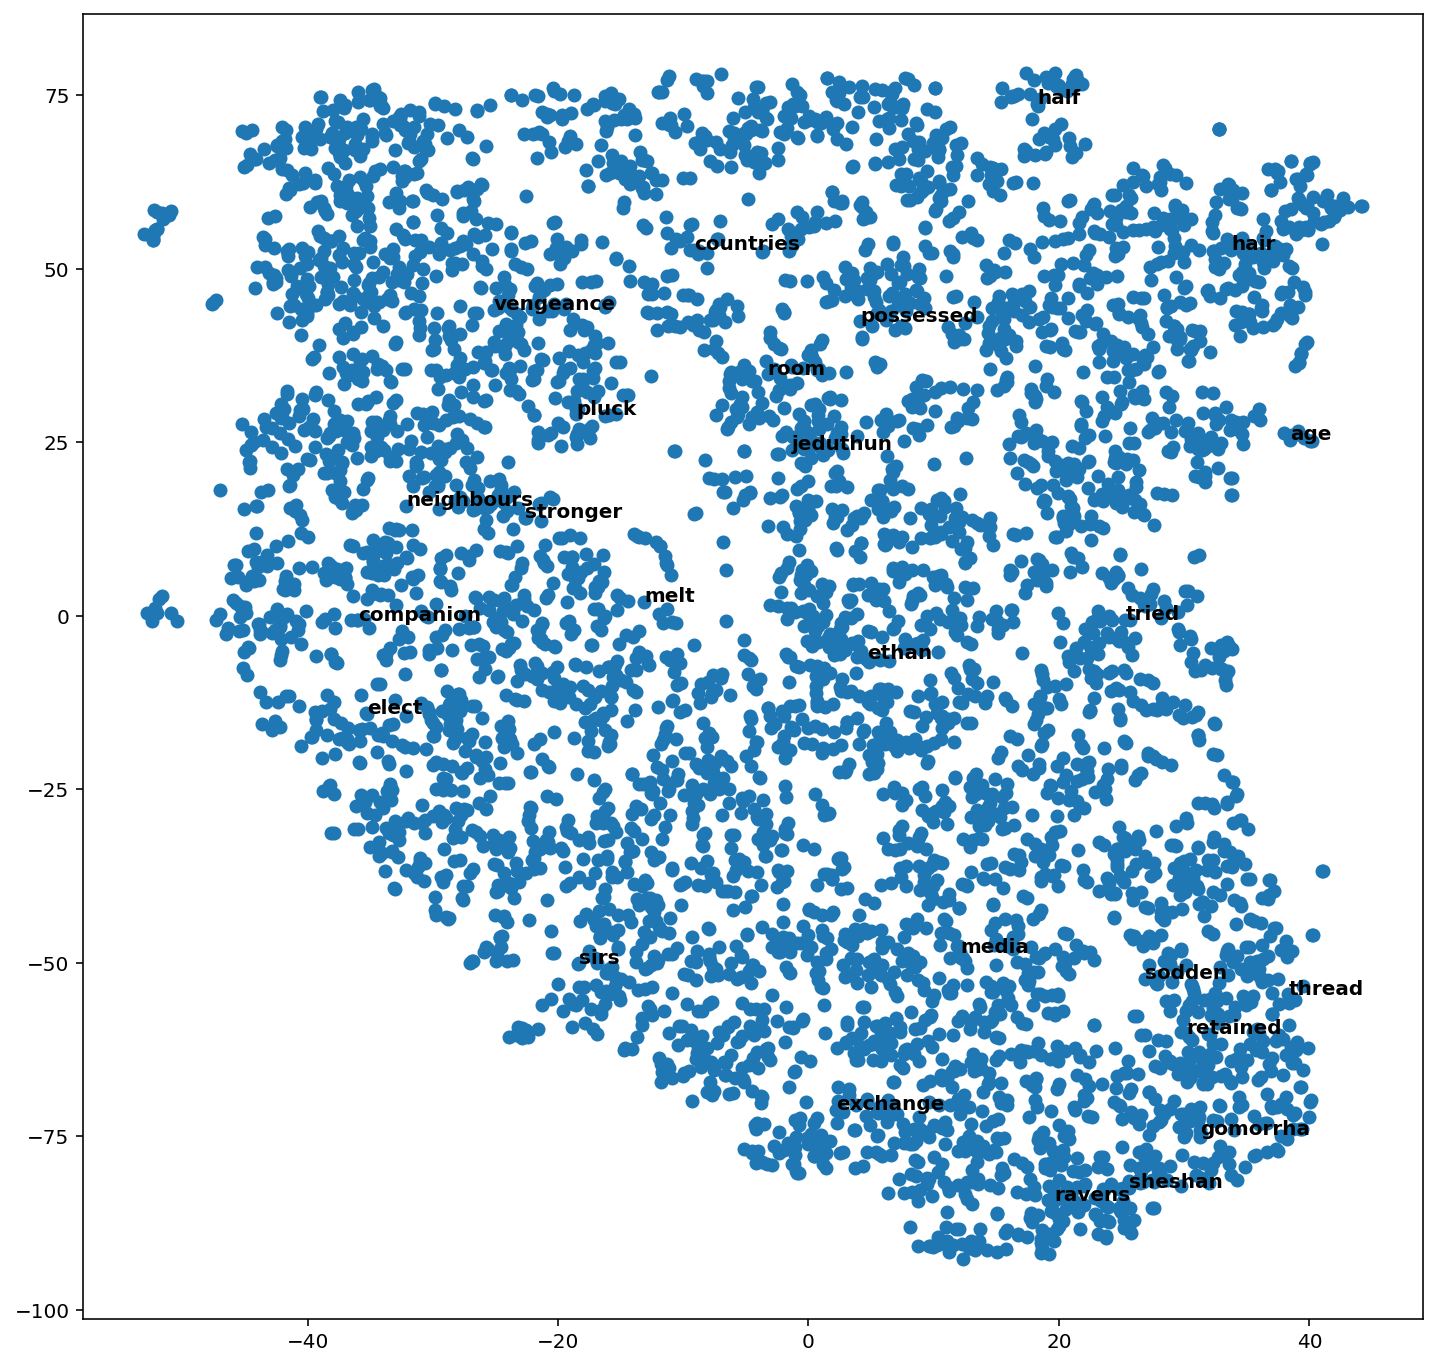

In [35]:
plot_with_matplotlib(x_vals, y_vals, labels, 0)